In [ ]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Pour RNC
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

#Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [ ]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
print(" Nombre d'exemplaires : ",X.shape[0] , " et le nombre le caractéristiques(features) est : ",X.shape[1])

 Nombre d'exemplaires :  5000  et le nombre le caractéristiques(features) est :  400


In [ ]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
print("Le nombre d'étiquettes est : ",Y.shape[0])


Le nombre d'étiquettes est :  5000


##Les classes de notre dataset:

Changer le label de la classe 0 

Les différentes classes de notre dataset

In [ ]:
Y[Y == 10] = 0

In [ ]:
np.unique(Y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Affichage d'un exemple de notre dataset

Donnée[2222] :  [ 12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12
  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12
  12  12  12  12  12  12  12  12  12  12  12  12  12  12   6   3  11  12
  12  12  12  12  12  12  12  12  12  12  12  12  12  12  11   5  57  81
  13  11  12  12  12  12  12  12  12  12  12  12  12  12  12   7   7 117
 221 231 106   7  12  12  12  12  12  12  12  12  12  12  12  11   6  42
 124 229 249 247 188  20  11  12  12  12  12  12  12  12  12  12  11  14
  83 205 250 248 246 245 219  35   9  12  12  12  12  12  12  12  12  12
  10  18 137 215 193 154 171 249 223  54   8  12  12  12  12  12  12  12
  12  12  12  12   9  29   7   0  60 237 231  72   5  10  11  12  12  12
  12  12  12  12  12  12  11   7   8   4  29 196 240  89  14  20  17  12
  12  12  12  12  12  12  12   8   6  25  28  27  81 201 247 234 224 230
 167  22   9  12  12  12  11   7   7  46 107 180 185 186 239 241 242 245
 247 248 233  39   7  12  12  11  1

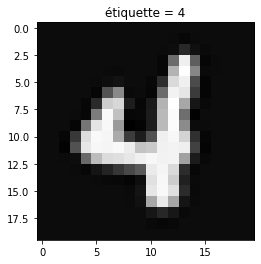

In [ ]:
print("Donnée[2222] : ",X[2222])
print("étiquette de donnée[2222] : ",Y[2222])
plt.title('étiquette = '+ str(Y[2222]))
plt.imshow(np.transpose(X[2222].reshape((20, 20))),cmap='gray')

## Afficher aléatoirement quelques données de notre base

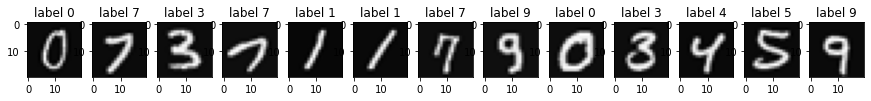

In [ ]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0]) #pich a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

# Implémentation des métriques

## Implementation de la matrice de confusion


In [ ]:
import seaborn as sns

# Methode pour calculer les VP et FP depuis la matrice de confusion pour une classe donnée
def mat_VP_FP(nbClasse,matConf):
  mat_vp_fp = np.zeros(shape=(nbClasse,2))
  for i in range(mat_vp_fp.shape[0]):
    mat_vp_fp[i][0]= matConf[i][i]
    mat_vp_fp[i][1] = np.sum(matConf[i:i+1]) - matConf[i][i]
  return mat_vp_fp
# Methode pour calculer les VP et NP depuis la matrice de confusion
def vp_np(mat_vp_fp,c):
  VP = mat_vp_fp[c][0]
  FP = mat_vp_fp[c][1]
  VN=0
  FN=0

  for i in range(mat_vp_fp.shape[0]):
    if(i != c):
    
      VN = VN + mat_vp_fp[i][0]
      FN = FN + mat_vp_fp[i][1]
    
  print("Pour la classe ",c)
  print("VP = ",VP," FP = ",FP," VN = ",VN," FN = ",FN) 

  return VP,FP,VN,FN


# Methode pour la mtrice de confusion
def ConfusionMatrix(l1, l2):
  # Calculer le nombre de classe du dataset
  nbr_classe = len(np.unique(l1)) # retourn toutes les classe du dataset
  '''
    Creer un dictionnaire de la forme classe_num : valeur ; exemple 0 : 0 et 1:1
  '''
  
  label_index = dict(zip(np.unique(l1), np.arange(nbr_classe)))
  
  # Creer un tableau (matrice de confusion) ayant une dimension nbr_Classe * nbrr_Classe
  result = np.zeros((nbr_classe, nbr_classe))
  # Boucle de calcul
  for i in range(len(l1)):
    # Implementer le nombre de la case
    result[label_index[l1[i]]][label_index[l2[i]]] += 1

  return result



def AfficherMatriceConfusion(size_figure ,matrice_Confusion):
  # Définir la taille de la figure
  plt.figure(figsize=size_figure)
  # Introduire notre matrice de confusion 
  ax = sns.heatmap(matrice_Confusion, annot=True, cmap='Reds')

  ax.set_title('Matrice de Confusion pour MNIST DIGITS CLASSIFICATION')
  ax.set_xlabel('\nValeurs predites')
  ax.set_ylabel('Valeurs réels ')

  ax.xaxis.set_ticklabels(['Vrai','Faux'])
  ax.yaxis.set_ticklabels(['Vrai','Faux'])
  
  plt.show()

## Rappel (sensibilité) :

In [ ]:
def rappel(VP,FN):
  r = VP / (VP+FN)
  return r

## Précision

In [ ]:
def precision(VP,FP):
  p = VP / (VP+FP)
  return p

## Taux de FP

In [ ]:
def taux_FP(FP,VP):
  t = FP / (FP+VP)
  return t


## Spécificité

In [ ]:
def specificite(VN,FP):
  s = VN / (VN + FP)
  return s

## implementation de la Courbe ROC

### Implementation d'une fonction de binarisation des probabilitées obtenu par chaque algorithme

In [ ]:
#Binariser le probleme(Le vecteur des proba) selon chaque classe
def bin_proba(pred_proba,c):
  proba = []
  for i in range(pred_proba.shape[0]):
    v = pred_proba[i]
    p1 = v[c]
    p2 = np.sum(v) - p1
    proba.append([p1,p2])
  return proba 

###Courbe roc

In [ ]:
def ROC(vect_classe,seuils,y_test, y_proba):
  for k in range(vect_classes.shape[0]):
    
    plt.figure(k)
    #binariser le vecteur des proba
    classe = vect_classes[k]
          
    p=bin_proba(y_proba,classe)
    p=np.array(p)
    
    coord = []
    for i in range(seuils.shape[0]):
      #Pour chaque seuil
      VP=0
      FP=0
      VN=0
      FN=0 
      for j in range(p.shape[0]):
        if(p[j][0] >= seuils[i]):
          #print(" proba de ",j," est sup au seuil ",seuils[i])
          if(y_test[j] == classe):
            #print("Ytt : ", Ytt[j]," est egale a classe")
            VP += 1
          else:
            #print("Ytt : ", Ytt[j]," n'est pas egale a classe")
            FP += 1
        else:
          
          if(y_test[j] != classe):
            VN += 1
          else:
            FN += 1       
      r = rappel(VP,FN)
      s = specificite(VN,FP)
      
      coord.append([r,s])

    coord = np.array(coord)

    plt.subplot(211)
    
    plt.title('classe = '+ str(classe))
    plt.plot(1-coord[:,1],coord[:,0])
    plt.show()

# Classification des digits en utilisant pluisieurs algorithmes de classification :
* KNN
* SVM
* Les arbres de decision
* Réseaux de noeurones artificielles 
* Réseaux de noeurones convolutifs


## Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt.
Cela sera fait en divison notre base de données (dataset) selon un ratio choisit pour les données de test et les données d'entrainement

In [ ]:
tRatio=2/3 # ratio pour l'entrainement
ttRatio=1/3 # ratio pour le test
n = np.int32(X.shape[0])
m1=np.around(n * tRatio)
m2=np.around(n * ttRatio)
print("m1 = ",m1," et m2 = ",m2," et la somme = ",m1+m2)

Xt, Xtt, Yt, Ytt = train_test_split(X,Y,test_size = ttRatio, train_size=tRatio )

print("Xt = ", Xt.shape)
print("Xtt = ", Xtt.shape)
print("Yt = ", Yt.shape)
print("Ytt = ", Ytt.shape)



m1 =  3333.0  et m2 =  1667.0  et la somme =  5000.0
Xt =  (3333, 400)
Xtt =  (1667, 400)
Yt =  (3333,)
Ytt =  (1667,)


# Méthode 0: K- Plus Proches Voisins (KNN)

In [ ]:
# La distance : euclidienne
import math
from collections import Counter
def distance_euclidienne(X, Y):
  s = 0
  for i in range(400):
    s = s + ((X[i]-Y[i])**2)
  return (s)**(1/2)

def distance_manhatthan(X,Y):
  s = 0
  for i in range(400):
    s = s + abs(Y[i] - X[i])
  return s
## KNN avec la distance euclidienne
def KNN(x,Xt,Yt,K):
  
  #creer et initialiser le vecteur des distance a -99 de taille K
  dist = [(-99) for i in range(K)]
  et = np.zeros_like(dist)

  
  #print(dist)
  #print(et)
  #print(len(Xt))

  for k in range(len(Xt)):
    d = distance_euclidienne(Xt[k],x)
    

    j=0
    while(j<K):
      if(dist[j]== -99):
        dist[j]=d
        et[j]=Yt[k]
      else:
        j=j+1  
    if(j==K):
      maxVal = np.max(dist)
      if(d<maxVal):
        i=0
        while(dist[i] != maxVal):
          i=i+1
        dist[i]=d
        et[i]=Yt[k]
        #print(Yt[k])
  print("Le vecteur des distances : ",dist)
  print("Le vecteur des étiquettes : ",et)
  
  #chercher l'etiquette qui a le plus d'occurances

  arr = np.array(et)
  print("arr : ",arr)
  m=0
  #while(m<K):
   # maxEt = 0
    #nbET = arr.tolist().count(et[m])
    #if(nbET > maxEt):
     # xx = et[m]
      #maxEt = nbET
      #m=m+1
      
    #else:
     # m=m+1
    
  xx = np.argmax(np.bincount(arr))
  ##xx = arr[indice]      
  print("xx = : ",xx)
  return xx
## KNN avec la distance de manhattan
def KNN_manatthan(x,Xt,Yt,K):
  
  #creer et initialiser le vecteur des distance a -99 de taille K
  dist = [(-99) for i in range(K)]
  et = np.zeros_like(dist)

  
  #print(dist)
  #print(et)
  #print(len(Xt))

  for k in range(len(Xt)):
    d = distance_manhatthan(Xt[k],x)
    

    j=0
    while(j<K):
      if(dist[j]== -99):
        dist[j]=d
        et[j]=Yt[k]
      else:
        j=j+1  
    if(j==K):
      maxVal = np.max(dist)
      if(d<maxVal):
        i=0
        while(dist[i] != maxVal):
          i=i+1
        dist[i]=d
        et[i]=Yt[k]
        #print(Yt[k])
  print("Le vecteur des distances : ",dist)
  print("Le vecteur des étiquettes : ",et)
  
  #chercher l'etiquette qui a le plus d'occurances

  arr = np.array(et)
  print("arr : ",arr)
  m=0
  #while(m<K):
   # maxEt = 0
    #nbET = arr.tolist().count(et[m])
    #if(nbET > maxEt):
     # xx = et[m]
      #maxEt = nbET
      #m=m+1
      
    #else:
     # m=m+1
    
  xx = np.argmax(np.bincount(arr))
  ##xx = arr[indice]      
  print("xx = : ",xx)
  return xx


## KNN avec la distance de Hamming 
from scipy.spatial.distance import hamming
def KNN_hamming(x,Xt,Yt,K):
  
  #creer et initialiser le vecteur des distance a -99 de taille K
  dist = [(-99) for i in range(K)]
  et = np.zeros_like(dist)

  
  #print(dist)
  #print(et)
  #print(len(Xt))

  for k in range(len(Xt)):
    d = hamming(Xt[k],x)
    

    j=0
    while(j<K):
      if(dist[j]== -99):
        dist[j]=d
        et[j]=Yt[k]
      else:
        j=j+1  
    if(j==K):
      maxVal = np.max(dist)
      if(d<maxVal):
        i=0
        while(dist[i] != maxVal):
          i=i+1
        dist[i]=d
        et[i]=Yt[k]
        #print(Yt[k])
  print("Le vecteur des distances : ",dist)
  print("Le vecteur des étiquettes : ",et)
  
  #chercher l'etiquette qui a le plus d'occurances

  arr = np.array(et)
  print("arr : ",arr)
  m=0
  #while(m<K):
   # maxEt = 0
    #nbET = arr.tolist().count(et[m])
    #if(nbET > maxEt):
     # xx = et[m]
      #maxEt = nbET
      #m=m+1
      
    #else:
     # m=m+1
    
  xx = np.argmax(np.bincount(arr))
  ##xx = arr[indice]      
  print("xx = : ",xx)
  return xx



## Quelques tests avec le model KNN pour deux images données

Le vecteur des distances :  [0.0, 758.3706217938561, 588.9838707468991, 809.4899628778605, 673.6853865121315]
Le vecteur des étiquettes :  [7 7 7 7 7]
arr :  [7 7 7 7 7]
xx = :  7
7


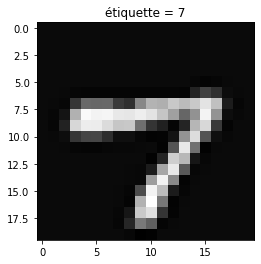

In [ ]:
#test du KNN
KNN(Xt[2],Xt,Yt,5)
print(Yt[2])
plt.title('étiquette = '+ str(Yt[2]))
plt.imshow(np.transpose(Xt[2].reshape((20, 20))),cmap='gray')




Le vecteur des distances :  [840.9613546412226, 842.2707403204744, 845.9296661070588]
Le vecteur des étiquettes :  [4 4 4]
arr :  [4 4 4]
xx = :  4
4


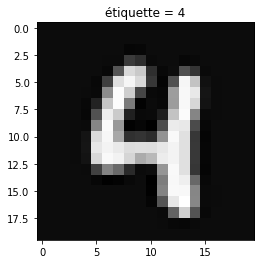

In [ ]:
KNN(Xtt[327],Xt,Yt,3)
print(Ytt[327])
plt.title('étiquette = '+ str(Ytt[327]))
plt.imshow(np.transpose(Xtt[327].reshape((20, 20))),cmap='gray')

## Le test de KNN en variant le K (le nombre de voisins)
Nous avons choisit de varier le K pour la même calsse afin de voir les différentes repércusiion sur l'execution du model.
Nous avons obtenu les résultats suivant 🇰
  * Pour K = 2:
    * Le temps d'execution est moins long que pour K = 5 et K = 3.
  * Pour K = 3:
    * Temps d'execution plus long que pour K = 2, ce qui est logique car l'algorithme calcul plus de distance vu que le nombre de voisin a augmenté. 
  * Pour K = 5 :
    * Temps d'execution très long, mais des resultats satisfaisant 

#### Pour k = 3

In [ ]:
#Classe 0 : chiffre 8
#Classe 1 : != chiffre 8
VP3=0
VN3=0
FP3=0
FN3=0
for p in range(len(Xtt)):
  xx=KNN(Xtt[p],Xt,Yt,3)
  if(Ytt[p] == 8):
    if(xx == Ytt[p]):
      VN3 = VN3+1
    else:
      FN3=FN3+1
  else:
    if(xx == Ytt[p]):
      VP3 = VP3+1
    else:
      FP3=FP3+1

#Evaluation
VN3,FN3,FP3,VP3 = mat_confusion(VP3,VN3,FP3,FN3)
r3=rappel(VP3,FN3)
p3=precision(VP3,FP3)
t3=taux_FP(FP3,VP3)
s3=specificite(VN3,FP3)
accuracy_knn_3 = (VP3 + VN3)/(VP3 + VN3 + FN3 +FP3)
print("Rappel3 = ",r3,"   precision3 = ",p3,"  taux_FP3 = ",t3," specificite = ",s3, "accuracy3 = ",accuracy_knn_3)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
xx = :  9
Le vecteur des distances :  [326.9770634157693, 236.69389514729778, 363.3386849758776]
Le vecteur des étiquettes :  [1 1 1]
arr :  [1 1 1]
xx = :  1
Le vecteur des distances :  [617.8308830092584, 620.5739279086739, 457.90064424501526]
Le vecteur des étiquettes :  [6 6 6]
arr :  [6 6 6]
xx = :  6
Le vecteur des distances :  [666.1628929923971, 675.3687881446699, 650.6150935845249]
Le vecteur des étiquettes :  [5 5 5]
arr :  [5 5 5]
xx = :  5
Le vecteur des distances :  [281.5776979805041, 736.6756409709772, 780.0576901742588]
Le vecteur des étiquettes :  [0 0 0]
arr :  [0 0 0]
xx = :  0
Le vecteur des distances :  [657.5826944194928, 616.4592443949559, 617.4163911008518]
Le vecteur des étiquettes :  [6 6 6]
arr :  [6 6 6]
xx = :  6
Le vecteur des distances :  [446.3160315292293, 669.6499085343028, 741.7607430971257]
Le vecteur des étiquettes :  [7 7 7]
arr :  [7 7 7]
xx = :  7
Le vecteur des distanc

#### Pour k = 2

In [ ]:
#Classe 0 : chiffre 8
#Classe 1 : != chiffre 8
VP2=0
VN2=0
FP2=0
FN2=0
for p in range(len(Xtt)):
  xx=KNN(Xtt[p],Xt,Yt,2)
  if(Ytt[p] == 8):
    if(xx == Ytt[p]):
      VN2 = VN2+1
    else:
      FN2=FN2+1
  else:
    if(xx == Ytt[p]):
      VP2 = VP2+1
    else:
      FP2=FP2+1

#Evaluation
VN2,FN2,FP2,VP2 = mat_confusion(VP2,VN2,FP2,FN2)
r2=rappel(VP2,FN2)
p2=precision(VP2,FP2)
t2=taux_FP(FP2,VP2)
s2=specificite(VN2,FP2)
accuracy_knn_2 = (VP2 + VN2)/(VP2 + VN2 + FN2 +FP2)
print("Rappel2 = ",r2,"   precision2 = ",p2,"  taux_FP2 = ",t2," specificite2 = ",s2," accuracy2 = ",accuracy_knn_2)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
xx = :  9
Le vecteur des distances :  [236.69389514729778, 326.9770634157693]
Le vecteur des étiquettes :  [1 1]
arr :  [1 1]
xx = :  1
Le vecteur des distances :  [617.8308830092584, 457.90064424501526]
Le vecteur des étiquettes :  [6 6]
arr :  [6 6]
xx = :  6
Le vecteur des distances :  [666.1628929923971, 650.6150935845249]
Le vecteur des étiquettes :  [5 5]
arr :  [5 5]
xx = :  5
Le vecteur des distances :  [736.6756409709772, 281.5776979805041]
Le vecteur des étiquettes :  [0 0]
arr :  [0 0]
xx = :  0
Le vecteur des distances :  [616.4592443949559, 617.4163911008518]
Le vecteur des étiquettes :  [6 6]
arr :  [6 6]
xx = :  6
Le vecteur des distances :  [446.3160315292293, 669.6499085343028]
Le vecteur des étiquettes :  [7 7]
arr :  [7 7]
xx = :  7
Le vecteur des distances :  [680.917763022819, 653.7025317374869]
Le vecteur des étiquettes :  [6 6]
arr :  [6 6]
xx = :  6
Le vecteur des distances :  [999.482

#### Pour k = 5

In [ ]:
#Classe 0 : chiffre 8
#Classe 1 : != chiffre 8
VP5=0
VN5=0
FP5=0
FN5=0
for p in range(len(Xtt)):
  xx=KNN(Xtt[p],Xt,Yt,5)
  if(Ytt[p] == 8):
    if(xx == Ytt[p]):
      VN5 = VN5+1
    else:
      FN5=FN5+1
  else:
    if(xx == Ytt[p]):
      VP5 = VP5+1
    else:
      FP5=FP5+1

#Evaluation
VN5,FN5,FP5,VP5 = mat_confusion(VP5,VN5,FP5,FN5)
r5=rappel(VP5,FN5)
p5=precision(VP5,FP5)
t5=taux_FP(FP5,VP5)
s5=specificite(VN5,FP5)
accuracy_knn_5 = (VP5 + VN5)/(VP5 + VN5 + FN5 +FP5)
print("Rappel5 = ",r5,"   precision5 = ",p5,"  taux_FP5 = ",t5," specificite5 =",s5,"accuracy5 = ",accuracy_knn_5)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
xx = :  9
Le vecteur des distances :  [431.97685123163717, 236.69389514729778, 401.7885015776335, 326.9770634157693, 363.3386849758776]
Le vecteur des étiquettes :  [1 1 1 1 1]
arr :  [1 1 1 1 1]
xx = :  1
Le vecteur des distances :  [662.3722518342688, 457.90064424501526, 620.5739279086739, 629.3123230956152, 617.8308830092584]
Le vecteur des étiquettes :  [6 6 6 6 6]
arr :  [6 6 6 6 6]
xx = :  6
Le vecteur des distances :  [760.0381569368737, 675.3687881446699, 650.6150935845249, 666.1628929923971, 783.0038314082506]
Le vecteur des étiquettes :  [5 5 5 5 5]
arr :  [5 5 5 5 5]
xx = :  5
Le vecteur des distances :  [736.6756409709772, 789.2452090446923, 790.1702348228513, 281.5776979805041, 780.0576901742588]
Le vecteur des étiquettes :  [0 0 0 0 0]
arr :  [0 0 0 0 0]
xx = :  0
Le vecteur des distances :  [679.8411579185243, 617.4163911008518, 666.9685149990215, 657.5826944194928, 616.4592443949559]
Le vecteu

## Application de KNN sur toute la base de données avec la distance euclidienne

In [ ]:
y_pred_knn = np.zeros_like(Ytt)

j =0
for i in range(Ytt.shape[0]):
  print("i = ",i)
  y_pred_knn[i] = KNN(Xtt[j],Xt,Yt,3)
  j=j+1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
i =  667
Le vecteur des distances :  [1069.925698354797, 1063.0141109129268, 1061.70052274641]
Le vecteur des étiquettes :  [6 6 4]
arr :  [6 6 4]
xx = :  6
i =  668
Le vecteur des distances :  [506.86388705450304, 523.4023309080692, 559.0438265467208]
Le vecteur des étiquettes :  [9 9 9]
arr :  [9 9 9]
xx = :  9
i =  669
Le vecteur des distances :  [579.7844427026306, 776.9967824901207, 913.9792120174287]
Le vecteur des étiquettes :  [8 8 8]
arr :  [8 8 8]
xx = :  8
i =  670
Le vecteur des distances :  [657.6830543658549, 670.7152898212474, 640.7776525441567]
Le vecteur des étiquettes :  [6 6 6]
arr :  [6 6 6]
xx = :  6
i =  671
Le vecteur des distances :  [612.4328534623204, 483.4221757429007, 540.9297551438634]
Le vecteur des étiquettes :  [6 6 6]
arr :  [6 6 6]
xx = :  6
i =  672
Le vecteur des distances :  [438.42901363846806, 460.9446821474351, 482.9886127022044]
Le vecteur des étiquettes :  [1 1 1]
arr

In [ ]:
y_pred_knn

array([2, 3, 6, ..., 5, 7, 8])

In [ ]:
y_pred_knn.shape, Ytt.shape

((1667,), (1667,))

### Application des metriques sur KNN avec la distance euclidienne

#### Matrice de confusion 

##### Matrice de confusion avec notre fonction

In [ ]:
matconf = ConfusionMatrix(Ytt, y_pred_knn)


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [ ]:
matconf

array([[185.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 169.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   7., 152.,   0.,   0.,   0.,   2.,   4.,   1.,   0.],
       [  0.,   2.,   1., 163.,   0.,   2.,   0.,   1.,   1.,   0.],
       [  0.,   6.,   0.,   0., 157.,   0.,   2.,   0.,   0.,  10.],
       [  3.,   2.,   0.,   1.,   3., 145.,   0.,   0.,   0.,   3.],
       [  1.,   0.,   0.,   0.,   0.,   0., 162.,   0.,   0.,   0.],
       [  1.,   3.,   1.,   0.,   1.,   0.,   0., 147.,   0.,   5.],
       [  1.,   3.,   1.,   2.,   1.,   4.,   2.,   0., 141.,   2.],
       [  1.,   0.,   1.,   4.,   4.,   0.,   0.,   2.,   0., 152.]])

In [ ]:
ConfusionMatrix(Ytt, y_pred_knn)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


array([[185.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 169.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   7., 152.,   0.,   0.,   0.,   2.,   4.,   1.,   0.],
       [  0.,   2.,   1., 163.,   0.,   2.,   0.,   1.,   1.,   0.],
       [  0.,   6.,   0.,   0., 157.,   0.,   2.,   0.,   0.,  10.],
       [  3.,   2.,   0.,   1.,   3., 145.,   0.,   0.,   0.,   3.],
       [  1.,   0.,   0.,   0.,   0.,   0., 162.,   0.,   0.,   0.],
       [  1.,   3.,   1.,   0.,   1.,   0.,   0., 147.,   0.,   5.],
       [  1.,   3.,   1.,   2.,   1.,   4.,   2.,   0., 141.,   2.],
       [  1.,   0.,   1.,   4.,   4.,   0.,   0.,   2.,   0., 152.]])

##### Matrice de confusion avec sklearn

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Ytt,y_pred_knn)

array([[185,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 169,   1,   2,   0,   0,   0,   0,   0,   0],
       [  0,   7, 152,   0,   0,   0,   2,   4,   1,   0],
       [  0,   2,   1, 163,   0,   2,   0,   1,   1,   0],
       [  0,   6,   0,   0, 157,   0,   2,   0,   0,  10],
       [  3,   2,   0,   1,   3, 145,   0,   0,   0,   3],
       [  1,   0,   0,   0,   0,   0, 162,   0,   0,   0],
       [  1,   3,   1,   0,   1,   0,   0, 147,   0,   5],
       [  1,   3,   1,   2,   1,   4,   2,   0, 141,   2],
       [  1,   0,   1,   4,   4,   0,   0,   2,   0, 152]])

#### Affichage de la matrice de confusion

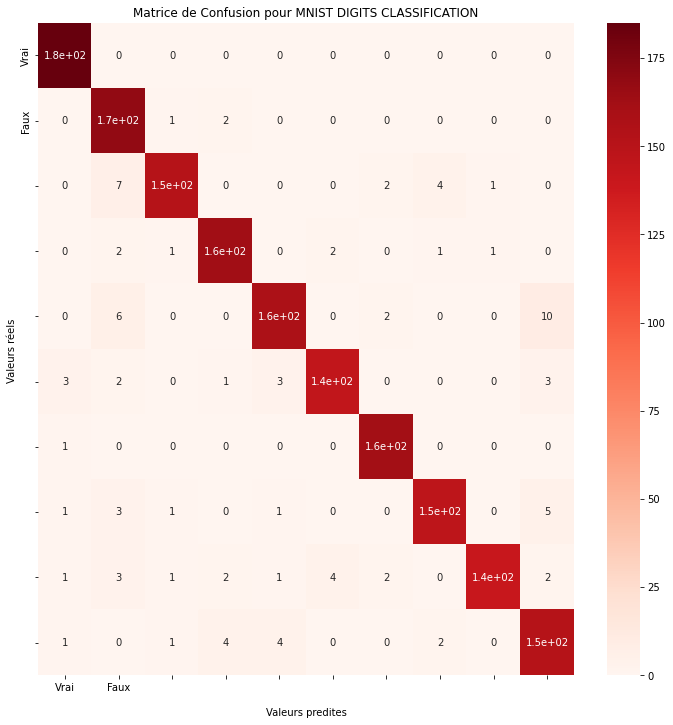

In [ ]:
AfficherMatriceConfusion((12,12),matconf)

### Calcul des metriques

#### Extraction VP, FP, FN, VN

In [ ]:
VP,FP,VN,FN = vp_np(mat_VP_FP(10,matconf),8)

Pour la classe  8
VP =  141.0  FP =  16.0  VN =  1432.0  FN =  78.0


#### Calcul : Rappel, Specificite, Taux de Faux Positif, Precision pour la classe 8

In [ ]:
rappel_classe1 = rappel(VP,FN)

In [ ]:
precision_classe1 = precision(VP,FP)

In [ ]:
taux_faux_positif_classe1 = taux_FP(FP,VP)

In [ ]:
specificite_classe1 = specificite(VN,FP)

In [ ]:
accuracy_knn = (VP + VN)/(VP + VN + FP+FN)

In [ ]:
print("classe8\n","rappel = ", rappel_classe1," precision = ",precision_classe1," taux de faux positif = ", taux_faux_positif_classe1," specificite = ",specificite_classe1," accuracy = ",accuracy_knn)

classe1
 rappel =  0.6438356164383562  precision =  0.8980891719745223  taux de faux positif =  0.10191082802547771  specificite =  0.988950276243094  accuracy =  0.9436112777444511


### Taux de l'algorithme KNN avec K = 3 et la distance euclidienne est de 94% pour la classe 8

## Application de KNN sur la base de données avec K = 3 et distance de manatthan

In [ ]:
y_pred_knn_manatthan = np.zeros_like(Ytt)

j =0
for i in range(Ytt.shape[0]):
  print("i = ",i)
  y_pred_knn_manatthan[i] = KNN_manatthan(Xtt[j],Xt,Yt,3)
  j=j+1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
i =  667
Le vecteur des distances :  [9251, 9716, 9670]
Le vecteur des étiquettes :  [6 4 4]
arr :  [6 4 4]
xx = :  4
i =  668
Le vecteur des distances :  [3857, 4142, 4880]
Le vecteur des étiquettes :  [9 9 9]
arr :  [9 9 9]
xx = :  9
i =  669
Le vecteur des distances :  [8354, 5632, 8776]
Le vecteur des étiquettes :  [8 8 8]
arr :  [8 8 8]
xx = :  8
i =  670
Le vecteur des distances :  [5105, 5047, 6170]
Le vecteur des étiquettes :  [6 6 6]
arr :  [6 6 6]
xx = :  6
i =  671
Le vecteur des distances :  [7035, 7398, 7541]
Le vecteur des étiquettes :  [6 6 6]
arr :  [6 6 6]
xx = :  6
i =  672
Le vecteur des distances :  [3192, 3235, 3220]
Le vecteur des étiquettes :  [1 1 1]
arr :  [1 1 1]
xx = :  1
i =  673
Le vecteur des distances :  [8160, 5302, 7472]
Le vecteur des étiquettes :  [8 8 8]
arr :  [8 8 8]
xx = :  8
i =  674
Le vecteur des distances :  [4462, 5964, 5967]
Le vecteur des étiquettes :  [7 7 7]
arr

### Afficher les predictions pour KNN avec manatrhan

### Matrice de confusion pour KNN avec la distance de manatthan

In [ ]:
y_pred_knn_manatthan

array([2, 3, 6, ..., 5, 7, 8])

#### Matrice de confusion avec notre fonction

In [ ]:
mat_conf_knn_manhattan = ConfusionMatrix(Ytt, y_pred_knn_manatthan)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [ ]:
mat_conf_knn_manhattan

array([[184.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 169.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.],
       [  0.,  10., 147.,   1.,   1.,   0.,   1.,   4.,   2.,   0.],
       [  1.,   4.,   1., 154.,   0.,   6.,   0.,   2.,   2.,   0.],
       [  1.,   8.,   1.,   0., 153.,   0.,   2.,   0.,   0.,  10.],
       [  5.,   2.,   0.,   3.,   2., 138.,   2.,   0.,   1.,   4.],
       [  0.,   1.,   0.,   0.,   0.,   1., 161.,   0.,   0.,   0.],
       [  1.,   6.,   0.,   0.,   2.,   0.,   0., 143.,   0.,   6.],
       [  1.,   5.,   2.,   5.,   3.,   3.,   1.,   0., 134.,   3.],
       [  1.,   0.,   1.,   4.,   5.,   0.,   0.,   4.,   0., 149.]])

#### Matrice de confusion avec sklearn

In [ ]:
confusion_matrix(Ytt, y_pred_knn_manatthan)

array([[184,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0, 169,   1,   1,   0,   0,   0,   1,   0,   0],
       [  0,  10, 147,   1,   1,   0,   1,   4,   2,   0],
       [  1,   4,   1, 154,   0,   6,   0,   2,   2,   0],
       [  1,   8,   1,   0, 153,   0,   2,   0,   0,  10],
       [  5,   2,   0,   3,   2, 138,   2,   0,   1,   4],
       [  0,   1,   0,   0,   0,   1, 161,   0,   0,   0],
       [  1,   6,   0,   0,   2,   0,   0, 143,   0,   6],
       [  1,   5,   2,   5,   3,   3,   1,   0, 134,   3],
       [  1,   0,   1,   4,   5,   0,   0,   4,   0, 149]])

#### Affichage de la matrice de confusion

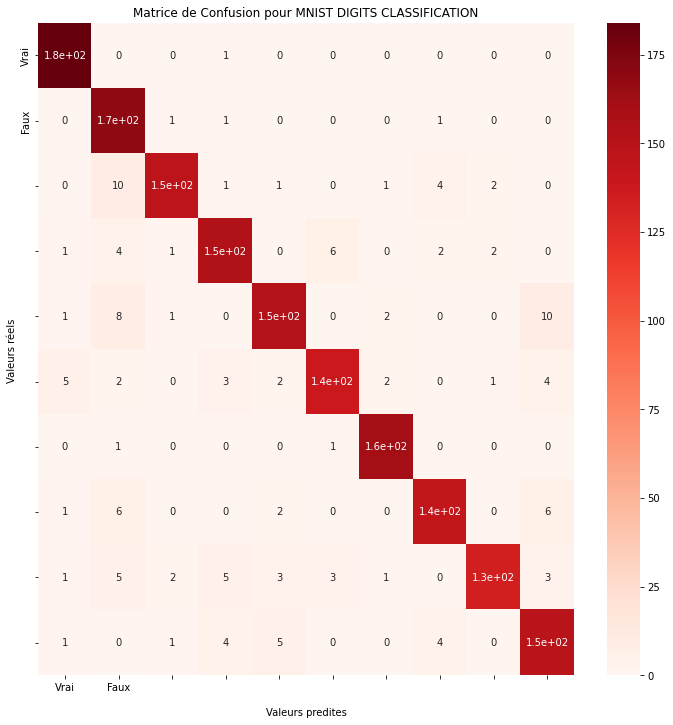

In [ ]:
AfficherMatriceConfusion((12,12),mat_conf_knn_manhattan)

### Calcul des metriques 

#### Extraction des VP, FP, VN, FN

In [ ]:
VP_manhattan,FP_manhattan,VN_manhattan,FN_manhattan = vp_np(mat_VP_FP(10,mat_conf_knn_manhattan),8)

Pour la classe  8
VP =  134.0  FP =  23.0  VN =  1398.0  FN =  112.0


#### Calcul des metriques : Rappel, Precision, Taux de Faux Positifs, Sensitivité pour manatthan 

In [ ]:
rappel_classe8 = rappel(VP_manhattan,FN_manhattan)

In [ ]:
precision_classe8 = precision(VP_manhattan,FP_manhattan)

In [ ]:
taux_faux_positif_classe8 = taux_FP(FP_manhattan,VP_manhattan)

In [ ]:
specificite_classe8 = specificite(VN_manhattan,FP_manhattan)

In [ ]:
accuracy_knn_manatthan = (VP_manhattan + VN_manhattan)/(VP_manhattan + VN_manhattan + FP_manhattan+FN_manhattan)

In [ ]:
print("classe8\n","rappel = ", rappel_classe8," precision = ",precision_classe8," taux de faux positif = ", taux_faux_positif_classe8," specificite = ",specificite_classe8," accuracy = ",accuracy_knn_manatthan)

classe8
 rappel =  0.5447154471544715  precision =  0.8535031847133758  taux de faux positif =  0.1464968152866242  specificite =  0.983814215341309  accuracy =  0.9190161967606478


### Taux de l'algorithme KNN avec k = 3 et la distance de manatthan est = 91% pour la classe 8

## Application de l'algorithme KNN sur la base de données avec K = 3 et la distance de hamming

In [ ]:
y_pred_knn_hamming= np.zeros_like(Ytt)

j =0
for i in range(Ytt.shape[0]):
  print("i = ",i)
  y_pred_knn_hamming[i] = KNN_hamming(Xtt[j],Xt,Yt,3)
  j=j+1

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
i =  667
Le vecteur des distances :  [0.4375, 0.44, 0.4425]
Le vecteur des étiquettes :  [6 6 2]
arr :  [6 6 2]
xx = :  6
i =  668
Le vecteur des distances :  [0.36, 0.3625, 0.3575]
Le vecteur des étiquettes :  [9 9 1]
arr :  [9 9 1]
xx = :  9
i =  669
Le vecteur des distances :  [0.495, 0.5025, 0.505]
Le vecteur des étiquettes :  [5 4 4]
arr :  [5 4 4]
xx = :  4
i =  670
Le vecteur des distances :  [0.3875, 0.41, 0.415]
Le vecteur des étiquettes :  [6 6 6]
arr :  [6 6 6]
xx = :  6
i =  671
Le vecteur des distances :  [0.465, 0.445, 0.455]
Le vecteur des étiquettes :  [5 6 9]
arr :  [5 6 9]
xx = :  5
i =  672
Le vecteur des distances :  [0.245, 0.2575, 0.255]
Le vecteur des étiquettes :  [1 1 1]
arr :  [1 1 1]
xx = :  1
i =  673
Le vecteur des distances :  [0.3425, 0.4075, 0.34]
Le vecteur des étiquettes :  [8 5 8]
arr :  [8 5 8]
xx = :  8
i =  674
Le vecteur des distances :  [0.3625, 0.3525, 0.3675]
Le vecte

### Afficher les prediction pour KNN avec hamming

In [ ]:
y_pred_knn_hamming

array([1, 1, 6, ..., 5, 7, 8])

### Matrice de confusion pour KNN avec la distance de hamming

#### Matrice de confusion avec notre fonction

In [ ]:
mat_conf_knn_hamming = ConfusionMatrix(Ytt, y_pred_knn_hamming)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [ ]:
mat_conf_knn_hamming

array([[124.,  31.,   2.,   3.,   7.,   9.,   3.,   0.,   4.,   2.],
       [  0., 172.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  2., 102.,  40.,   2.,   2.,   6.,   7.,   5.,   0.,   0.],
       [  2.,  98.,   2.,  40.,   9.,   7.,   5.,   2.,   4.,   1.],
       [  0.,  52.,   5.,   5.,  80.,   3.,   2.,   1.,   1.,  26.],
       [  2.,  60.,   1.,  10.,   9.,  52.,   8.,   2.,   2.,  11.],
       [  0.,  36.,   2.,   3.,   6.,   2., 109.,   0.,   2.,   3.],
       [  0.,  32.,   1.,   1.,   8.,   0.,   0.,  97.,   0.,  19.],
       [  1.,  74.,   2.,   3.,  11.,   6.,   4.,   4.,  42.,  10.],
       [  1.,  23.,   1.,   1.,   8.,   0.,   0.,  13.,   2., 115.]])

#### Matrice de confusion avec Sklearn

In [ ]:
confusion_matrix(Ytt, y_pred_knn_hamming)

array([[124,  31,   2,   3,   7,   9,   3,   0,   4,   2],
       [  0, 172,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2, 102,  40,   2,   2,   6,   7,   5,   0,   0],
       [  2,  98,   2,  40,   9,   7,   5,   2,   4,   1],
       [  0,  52,   5,   5,  80,   3,   2,   1,   1,  26],
       [  2,  60,   1,  10,   9,  52,   8,   2,   2,  11],
       [  0,  36,   2,   3,   6,   2, 109,   0,   2,   3],
       [  0,  32,   1,   1,   8,   0,   0,  97,   0,  19],
       [  1,  74,   2,   3,  11,   6,   4,   4,  42,  10],
       [  1,  23,   1,   1,   8,   0,   0,  13,   2, 115]])

#### Affichage de la matrice de confusion

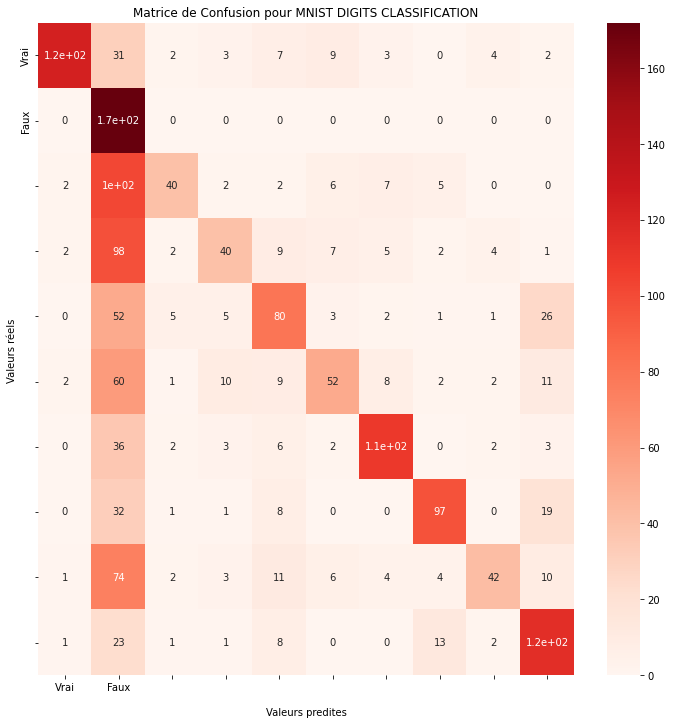

In [ ]:
AfficherMatriceConfusion((12,12),mat_conf_knn_hamming)

### Calcul des metriques

#### Extraction des VP,FP,VN,FN

In [ ]:
VP_hamming,FP_hamming,VN_hamming,FN_hamming = vp_np(mat_VP_FP(10,mat_conf_knn_hamming),8)

Pour la classe  8
VP =  42.0  FP =  115.0  VN =  829.0  FN =  681.0


#### Calcul des metriques : Rappel, Precision, Taux de Faux Positifs, Sensitivité pour la classe 8

In [ ]:
rappel_classe8 = rappel(VP_hamming,FN_hamming)

In [ ]:
precision_classe8 = precision(VP_hamming,FP_hamming)

In [ ]:
taux_faux_positif_classe8 = taux_FP(FP_hamming,VP_hamming)

In [ ]:
specificite_classe8 = specificite(VN_hamming,FP_hamming)

In [ ]:
accuracy_knn_hamming = (VP_hamming + VN_hamming)/(VP_hamming+ VN_hamming + FP_hamming + FN_hamming)

In [ ]:
print("classe8\n","rappel = ", rappel_classe8," precision = ",precision_classe8," taux de faux positif = ", taux_faux_positif_classe8," specificite = ",specificite_classe8," accuracy = ",accuracy_knn_hamming)

classe8
 rappel =  0.058091286307053944  precision =  0.267515923566879  taux de faux positif =  0.732484076433121  specificite =  0.878177966101695  accuracy =  0.52249550089982


#### Taux de precision de KNN avec K = 3 et distance de hamming pour la classe 8 est = 52%

## Donc pour une classe choisit (classe 8 ) l'algorithme avec k = 3 et avec la distance euclidienne est le meilleur

# SVM

## Model SVM

In [ ]:
#Créer le modèle
model= svm.SVC(kernel='linear',probability = True) 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred_svm = model.predict(Xtt)

## Affichage resultat d'un test sur SVM

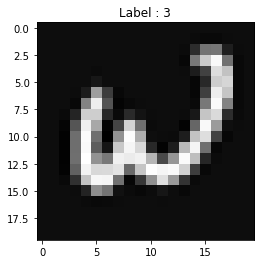

In [ ]:
c = 9
plt.title("Label : " + str(y_pred_svm[c]))
plt.imshow(Xtt[c].reshape(20,20), cmap= "gray")

## Score du model svm

In [ ]:
model.score(Xtt, Ytt)

0.9220155968806238

## Calcul des predictions sous forme de probabilitées

In [ ]:
proba_svm = model.predict_proba(Xtt)

In [ ]:
proba_svm[0]
prova = proba_svm[:,1]

In [ ]:
y_pred_svm

array([2, 3, 6, ..., 5, 7, 8])

## Application des metriques sur SVM

### Matrice de confusion

#### Matrice de confusion avec notre fonction

In [ ]:
ConfusionMatrix(Ytt, y_pred_svm)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


array([[183.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.],
       [  0., 167.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   1.],
       [  1.,   0., 154.,   4.,   4.,   0.,   1.,   2.,   0.,   0.],
       [  0.,   2.,   3., 153.,   0.,   5.,   0.,   2.,   4.,   1.],
       [  1.,   2.,   3.,   0., 161.,   0.,   1.,   1.,   1.,   5.],
       [  2.,   3.,   2.,   3.,   1., 141.,   1.,   0.,   2.,   2.],
       [  1.,   0.,   0.,   0.,   0.,   2., 160.,   0.,   0.,   0.],
       [  2.,   2.,   1.,   1.,   2.,   0.,   0., 144.,   0.,   6.],
       [  1.,   6.,   6.,   3.,   2.,   6.,   2.,   0., 130.,   1.],
       [  0.,   0.,   3.,   2.,   7.,   1.,   0.,   7.,   0., 144.]])

#### Matrice de confusion avec Sklearn

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Ytt, y_pred_svm)

array([[183,   0,   0,   0,   0,   2,   0,   0,   0,   0],
       [  0, 167,   2,   0,   0,   0,   0,   1,   1,   1],
       [  1,   0, 154,   4,   4,   0,   1,   2,   0,   0],
       [  0,   2,   3, 153,   0,   5,   0,   2,   4,   1],
       [  1,   2,   3,   0, 161,   0,   1,   1,   1,   5],
       [  2,   3,   2,   3,   1, 141,   1,   0,   2,   2],
       [  1,   0,   0,   0,   0,   2, 160,   0,   0,   0],
       [  2,   2,   1,   1,   2,   0,   0, 144,   0,   6],
       [  1,   6,   6,   3,   2,   6,   2,   0, 130,   1],
       [  0,   0,   3,   2,   7,   1,   0,   7,   0, 144]])

Juste un verification manuelle des résultats

In [ ]:
matc = np.zeros((10,10))

for i in range(Ytt.shape[0]):
  matc[Ytt[i]][y_pred_svm[i]] +=1
print(matc)

[[183.   0.   0.   0.   0.   2.   0.   0.   0.   0.]
 [  0. 167.   2.   0.   0.   0.   0.   1.   1.   1.]
 [  1.   0. 154.   4.   4.   0.   1.   2.   0.   0.]
 [  0.   2.   3. 153.   0.   5.   0.   2.   4.   1.]
 [  1.   2.   3.   0. 161.   0.   1.   1.   1.   5.]
 [  2.   3.   2.   3.   1. 141.   1.   0.   2.   2.]
 [  1.   0.   0.   0.   0.   2. 160.   0.   0.   0.]
 [  2.   2.   1.   1.   2.   0.   0. 144.   0.   6.]
 [  1.   6.   6.   3.   2.   6.   2.   0. 130.   1.]
 [  0.   0.   3.   2.   7.   1.   0.   7.   0. 144.]]


### Affichage de la Matrice de Confusion: 

Utilisation de la libraire seaborn. Cette librarie offre de nombreses methodes d'affichage, elle est très utilisé dans le domaine de la représentation graphique et de l'imagerie

In [ ]:
matrice = ConfusionMatrix(Ytt, y_pred_svm)


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


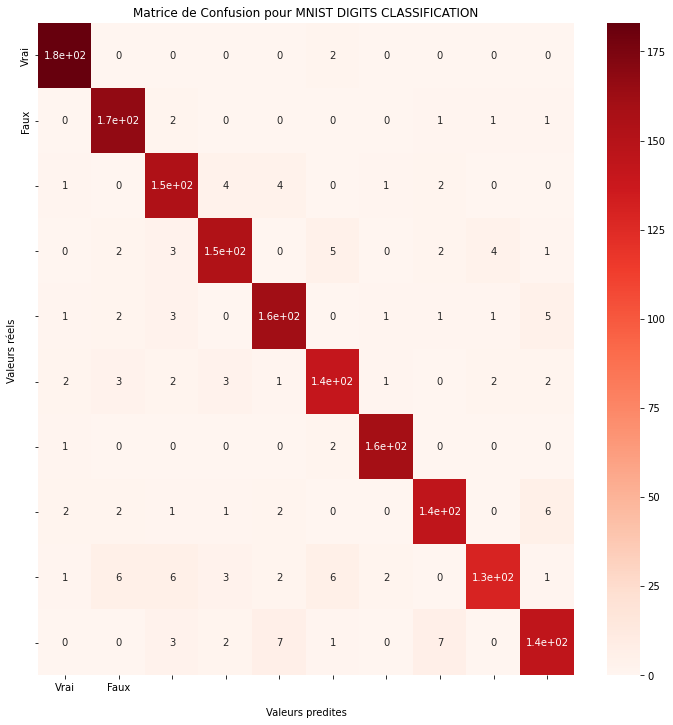

In [ ]:
AfficherMatriceConfusion((12,12),matrice)

### Calcule des metriques :  Rappel, Specificité , Precision, Taux de Faux Positifs pour la classe 8

In [ ]:
VP,FP,VN,FN = vp_np(mat_VP_FP(10,matrice),8)


Pour la classe  8
VP =  130.0  FP =  27.0  VN =  1407.0  FN =  103.0


In [ ]:
rappel_classe8 = rappel(VP,FN)

In [ ]:
precision_classe8 = precision(VP,FP)

In [ ]:
taux_faux_positif_classe8 = taux_FP(FP,VP)

In [ ]:
specificite_classe8 = specificite(VN,FP)

In [ ]:
print("classe8\n","rappel = ", rappel_classe8," precision = ",precision_classe8," taux de faux positif = ", taux_faux_positif_classe8," specificite = ",specificite_classe8)

classe8
 rappel =  0.5579399141630901  precision =  0.8280254777070064  taux de faux positif =  0.17197452229299362  specificite =  0.9811715481171548


## Courbe ROC

### Définition des seuils, le calcul se fait pour chaque classe

In [ ]:
vect_classes = np.array([0,1,2,3,4,5,6,7,8,9])
seuils = [0.1,0.2,0.4,0.6,0.8,0.9]
seuils = np.array(seuils)

### Affichage de la courbe roc pour chaque classe de notre dataset

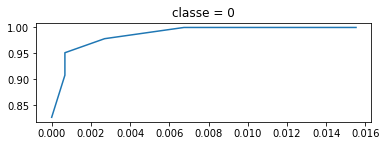

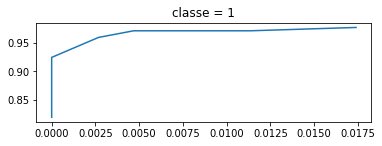

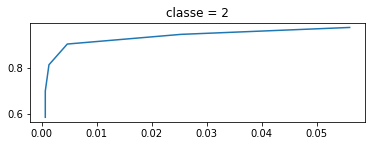

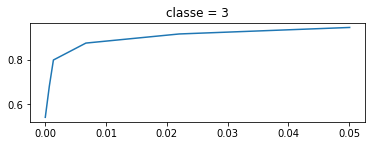

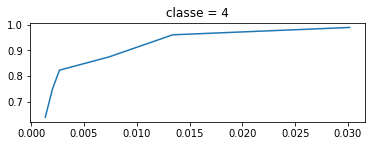

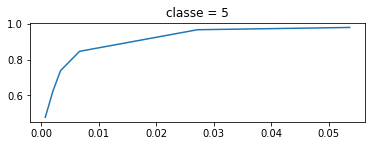

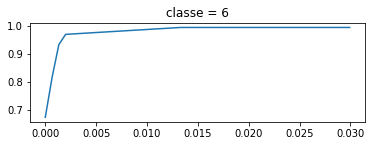

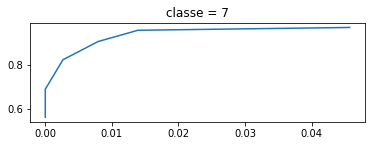

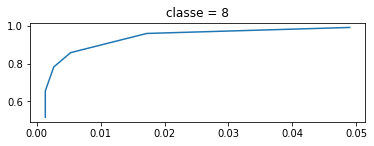

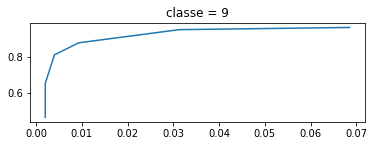

In [ ]:
ROC(vect_classes,seuils,Ytt,proba_svm)

# Arbres de décision

## Model d'arbre de decision (Decision Tree classifier)

In [ ]:
# Créer le modèle
model = DecisionTreeClassifier(max_depth=5) # definir une profondeur pour notre arbre, ainsi l'arbre s'arretera à une profondeur donnée
## Car si on ne fixe pas la profondeur, l'arbre va grandir jusqu'à atteindre le moins d'échantillons possible dans chauqe feuille
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred_tree = model.predict(Xtt)

## Affichage du tableau des predicitions du model

In [ ]:
y_pred_tree

array([2, 8, 6, ..., 5, 7, 8])

## Calculer les probabilitées retournées par l'arbre de decision. 

**P.S: Si lors de l'initialisation du model, on ne fixe pas la profondeur de l'arbre, nous aurons non pas des probabilitées du genre (0.2,0.25..) mais des probabilitées binairisées vu que l'arbre va grandire jusqu'à la profondeur où chaque feuille aura le moins d'echantillons possible**

In [ ]:
y_proba_tree = model.predict_proba(Xtt)

### Affichager des probabilitées de l'arbre de decision 

In [ ]:
y_proba_tree

array([[0.        , 0.09090909, 0.77272727, ..., 0.01363636, 0.01363636,
        0.00909091],
       [0.0657277 , 0.05164319, 0.02347418, ..., 0.01408451, 0.21126761,
        0.03286385],
       [0.024     , 0.        , 0.128     , ..., 0.        , 0.136     ,
        0.016     ],
       ...,
       [0.        , 0.        , 0.008     , ..., 0.        , 0.008     ,
        0.        ],
       [0.00387597, 0.00387597, 0.        , ..., 0.95348837, 0.00387597,
        0.00775194],
       [0.03289474, 0.00657895, 0.00657895, ..., 0.        , 0.88157895,
        0.        ]])

## Calcul du score de l'arbre de decision

In [ ]:
model.score(Xtt, Ytt)

0.6874625074985004

## Affichage d'un resultat de test sur les Arbres de décision

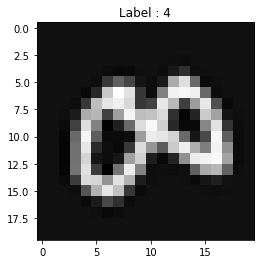

In [ ]:
plt.title("Label : " + str(y_pred_tree[20]))
plt.imshow(Xt[20].reshape(20,20), cmap= "gray")

## Matrice de confusion

### Matrice de confusion avec notre fonction

In [ ]:
ConfusionMatrix(Ytt, y_pred_tree)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


array([[155.,   0.,   6.,   5.,   4.,   3.,   1.,   0.,  10.,   1.],
       [  0., 138.,  21.,   1.,   0.,   1.,   1.,   2.,   8.,   0.],
       [  0.,   4., 118.,   6.,   4.,   2.,   6.,   8.,  16.,   2.],
       [  1.,   4.,  14.,  79.,   9.,   6.,   1.,   2.,  34.,  20.],
       [  3.,   0.,   5.,   0., 127.,   0.,   3.,   0.,   8.,  29.],
       [  7.,   1.,  10.,  13.,   9.,  65.,  10.,   1.,  16.,  25.],
       [  3.,   1.,  16.,   0.,  17.,   3.,  91.,   3.,  21.,   8.],
       [  2.,   2.,   3.,   1.,   6.,   0.,   1., 124.,   5.,  14.],
       [  1.,   4.,  10.,   4.,   7.,   1.,   8.,   4., 106.,  12.],
       [  1.,   4.,   3.,   5.,   3.,   0.,   0.,   1.,   4., 143.]])

### Matrice de confusion avec Sklearn

In [ ]:
confusion_matrix(Ytt,y_pred_tree)

array([[155,   0,   6,   5,   4,   3,   1,   0,  10,   1],
       [  0, 138,  21,   1,   0,   1,   1,   2,   8,   0],
       [  0,   4, 118,   6,   4,   2,   6,   8,  16,   2],
       [  1,   4,  14,  79,   9,   6,   1,   2,  34,  20],
       [  3,   0,   5,   0, 127,   0,   3,   0,   8,  29],
       [  7,   1,  10,  13,   9,  65,  10,   1,  16,  25],
       [  3,   1,  16,   0,  17,   3,  91,   3,  21,   8],
       [  2,   2,   3,   1,   6,   0,   1, 124,   5,  14],
       [  1,   4,  10,   4,   7,   1,   8,   4, 106,  12],
       [  1,   4,   3,   5,   3,   0,   0,   1,   4, 143]])

### Affichage de la matrice de Confusion

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


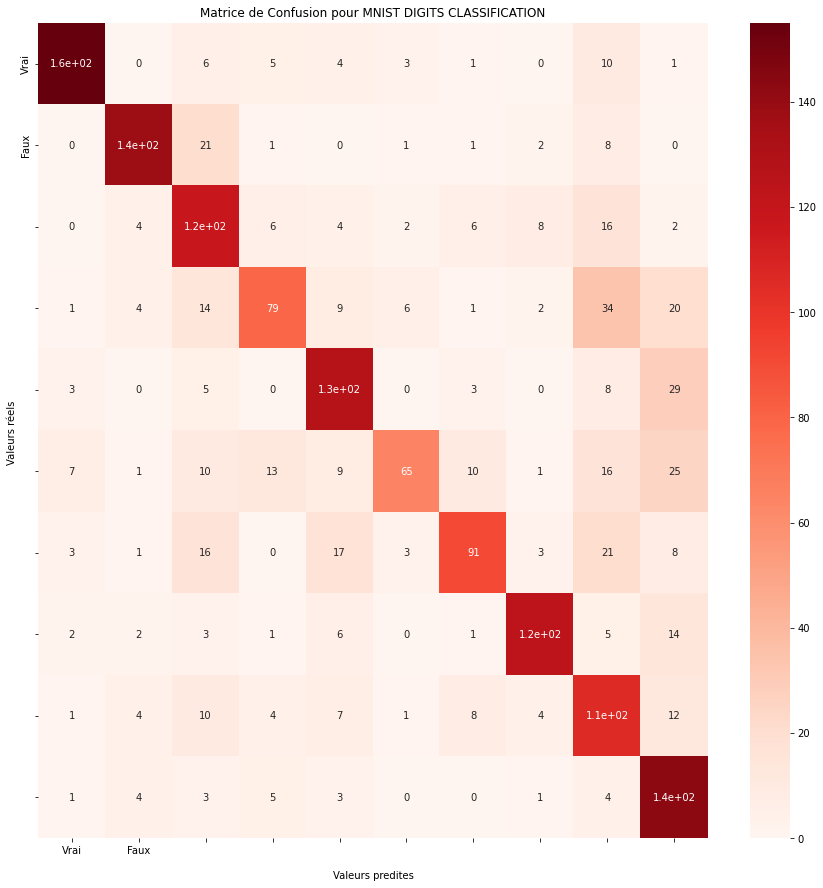

In [ ]:
m = ConfusionMatrix(Ytt, y_pred_tree)
AfficherMatriceConfusion((15,15),m)

## Calcul des metriques

### Extraction des VP, FP, VN, FN

In [ ]:
VP,FP,VN,FN = vp_np(mat_VP_FP(10,m),8)

Pour la classe  8
VP =  106.0  FP =  51.0  VN =  1040.0  FN =  470.0


### Calcule des metriques : Rappel, Specificité, Precision, Taux de Faux Positifs pour la classe 8

In [ ]:
rappel_classe8 = rappel(VP,FN)

In [ ]:
precision_classe8 = precision(VP,FP)

In [ ]:
taux_faux_positif_classe8 = taux_FP(FP,VP)

In [ ]:
specificite_classe8 = specificite(VP,FP)

In [ ]:
print("classe8\n","rappel = ", rappel_classe8," precision = ",precision_classe8," taux de faux positif = ", taux_faux_positif_classe8," specificite = ",specificite_classe8)

classe8
 rappel =  0.1840277777777778  precision =  0.6751592356687898  taux de faux positif =  0.3248407643312102  specificite =  0.6751592356687898


## Courbe ROC

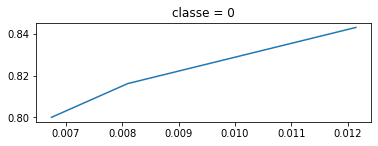

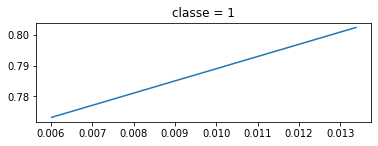

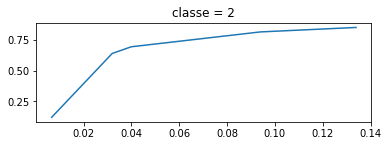

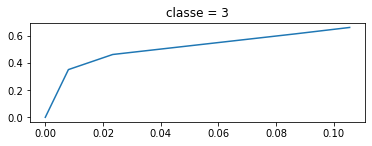

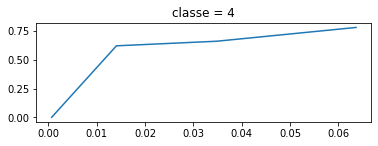

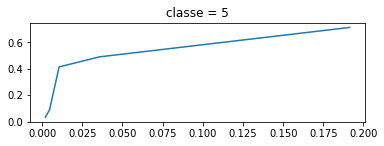

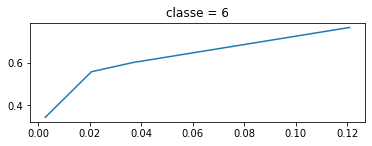

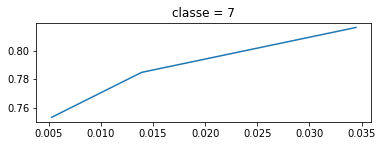

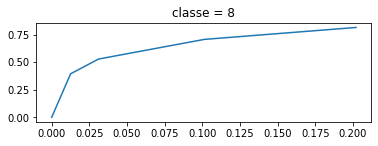

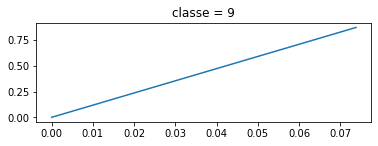

In [ ]:
ROC(vect_classes,seuils,Ytt,y_proba_tree)

# Réseau de noeurones artificielles :
Dans cette partie nous allons utilisé les réseaux de noeurones artificielles.

Nous avons asusi voulu implementer notre propre model afin d'avoir une petite introduction à tensorflow vu que ces models sont très utilisés en computer vision.

## Model 1 

In [ ]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

### Calcul des probabilitées pour une image 

In [ ]:
model.predict([Xtt[7,:]])

array([4])

## Precision du model 1

In [ ]:
model.score(Xtt, Ytt)

0.19314285714285714

## Prediction du model 1

### Calcul des predicitions du model 1

In [ ]:
y_pred_ann = model.predict(Xtt)

### Affichage des predictions du model 1

In [ ]:
y_pred_ann

array([4, 4, 4, ..., 4, 4, 1])

## Probabilitées du model 1

### Calcul des probabilitées du model 1

In [ ]:
y_proba_ann = model.predict_proba(Xtt)

### Affichage des probabilitées du model 1

In [ ]:
y_proba_ann

array([[1.08641228e-01, 3.74949306e-02, 1.04681221e-01, ...,
        1.05070678e-01, 1.01551602e-01, 1.08836113e-01],
       [1.08641228e-01, 3.74949306e-02, 1.04681221e-01, ...,
        1.05070678e-01, 1.01551602e-01, 1.08836113e-01],
       [1.08641228e-01, 3.74949306e-02, 1.04681221e-01, ...,
        1.05070678e-01, 1.01551602e-01, 1.08836113e-01],
       ...,
       [1.08641228e-01, 3.74949306e-02, 1.04681221e-01, ...,
        1.05070678e-01, 1.01551602e-01, 1.08836113e-01],
       [1.08641228e-01, 3.74949306e-02, 1.04681221e-01, ...,
        1.05070678e-01, 1.01551602e-01, 1.08836113e-01],
       [6.59273380e-38, 9.99999088e-01, 1.48614348e-33, ...,
        1.40074472e-17, 9.11926838e-07, 2.15894204e-32]])

## Matrice de confusion pour le model 1

In [ ]:
matrice_ann = ConfusionMatrix(Ytt, y_pred_ann)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [ ]:
ConfusionMatrix(Ytt, y_pred_ann)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


array([[  0.,   0.,   0.,   0., 354.,   0.,   0.,   0.,   0.,   0.],
       [  0., 338.,   0.,   0.,  13.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   2.,   0.,   0., 352.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0., 357.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0., 336.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   1.,   0.,   0., 348.,   0.,   0.,   0.,   2.,   0.],
       [  0.,   2.,   0.,   0., 341.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   4.,   0.,   0., 345.,   0.,   0.,   0.,   1.,   0.],
       [  0.,   3.,   0.,   0., 345.,   0.,   0.,   0.,   2.,   0.],
       [  0.,   4.,   0.,   0., 346.,   0.,   0.,   0.,   1.,   0.]])

### Matrice de confusion du model 1 avec Sklearn

In [ ]:
confusion_matrix(Ytt,y_pred_ann)

array([[  0,   0,   0,   0, 354,   0,   0,   0,   0,   0],
       [  0, 338,   0,   0,  13,   0,   0,   0,   0,   0],
       [  0,   2,   0,   0, 352,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0, 357,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0, 336,   0,   0,   0,   1,   0],
       [  0,   1,   0,   0, 348,   0,   0,   0,   2,   0],
       [  0,   2,   0,   0, 341,   0,   0,   0,   0,   0],
       [  0,   4,   0,   0, 345,   0,   0,   0,   1,   0],
       [  0,   3,   0,   0, 345,   0,   0,   0,   2,   0],
       [  0,   4,   0,   0, 346,   0,   0,   0,   1,   0]])

### Affichage de la matrice de confusion

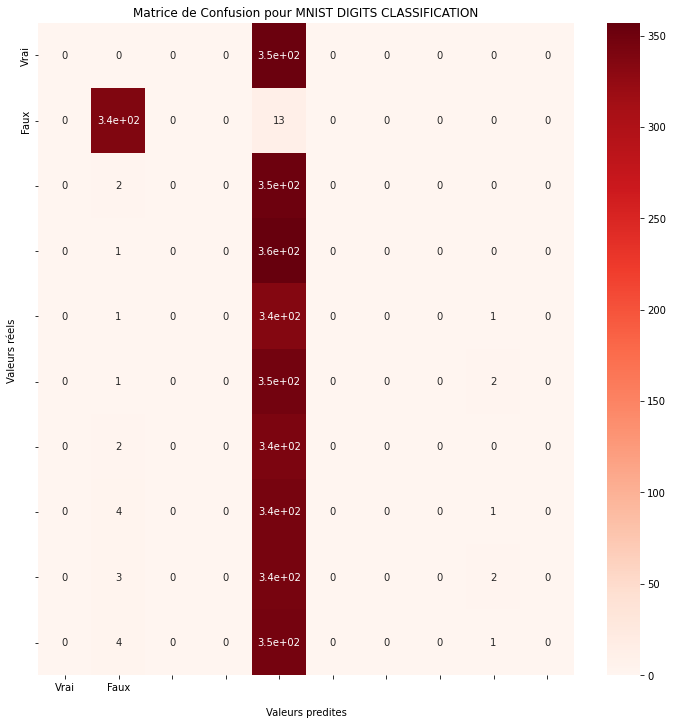

In [ ]:
AfficherMatriceConfusion((12,12),matrice_ann) 

## Calcul des metriques : Rappel, Specificité, Precision, Taux de Faux Positifs pour la classe 1

In [ ]:
VP,FP,VN,FN = vp_np(mat_VP_FP(10,matrice_ann),1)


Pour la classe  1
VP =  338.0  FP =  13.0  VN =  338.0  FN =  2811.0


In [ ]:
rappel_classe8 = rappel(VP,FN)

In [ ]:
precision_classe8 = precision(VP,FP)

In [ ]:
taux_faux_positif_classe8 = taux_FP(FP,VP)

In [ ]:
specificite_classe8 = specificite(VP,FP)

In [ ]:
print("classe1\n","rappel = ", rappel_classe8," precision = ",precision_classe8," taux de faux positif = ", taux_faux_positif_classe8," specificite = ",specificite_classe8)

classe1
 rappel =  0.10733566211495713  precision =  0.9629629629629629  taux de faux positif =  0.037037037037037035  specificite =  0.9629629629629629


## Courbe roc

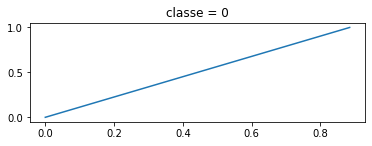

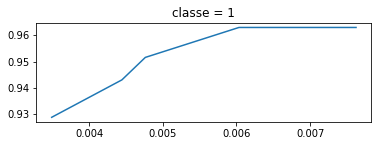

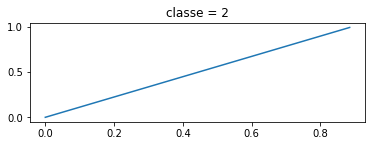

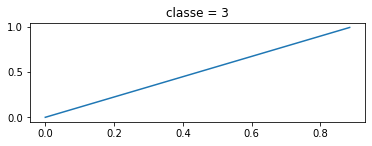

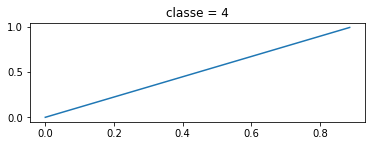

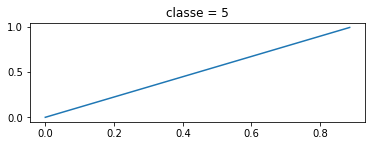

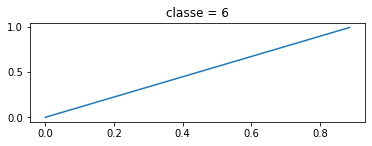

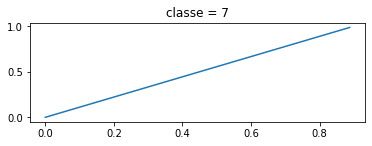

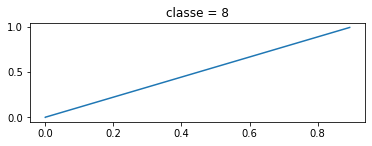

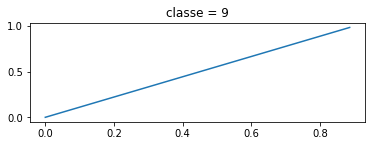

In [ ]:
ROC(vect_classes,seuils,Ytt,y_proba_ann)

# Notre modèle

## Nous avons divisé nos données

In [ ]:
Xt_rnn, Xtt_rnn, yt_rnn, ytt_rnn = train_test_split(X,Y, test_size = 0.25, random_state=42,shuffle=True) 

In [ ]:
Xt1 = Xt_rnn 
Xtt1 = Xtt_rnn 

## Modification de nos données afin qu'il puisse être compris pas le model

In [ ]:
# one hot code

xt = Xt1.reshape(len(Xt1),20*20)
xtt = Xtt1.reshape(len(Xtt1),20*20)

In [ ]:
xt.shape

(3750, 400)

## Création du model :
Dans cette section nous allons créer notre model. Notre model sera un model sequentiel. 

**Exemple:**
Si nous avons 2 layers (couche de noeurones ) 
alors le model sera sous cette frome :  Layer 1  -> Layer 2.

Maintenant, nous allons passé à l'architechture de notre model :

Nous avons choisit un seul layer pour le model. Notre choix ce porte sur le fait que nous n'avons pas beacoup de données d'entrainement, certe nous avons 3750 images de taille 400x400, mais si on ajoute beaucoup plus de layers, il se pourrait que notre model n'arrive pas à généraliser son apprentissage sur les données de test (c'est aprés avoir fait plusieurs expérimentation sur le nombre de layers et toutes les fonctions d'activation que nous somme arrivés à cette conclusion).

Enfin, Nous avons pris la fonction segmoid comme fonction d'activation de notre model. Une fonction d'activation peut être vu comme la façon (manière) que notre noeurones voit les données pour mieux les apprendre. Il existe plusieurs fonction d'activation : softmax, relu, sigmoid.


In [ ]:
from tensorflow.keras.layers import Dense
import tensorflow as tf
model_ann = tf.keras.models.Sequential([
                      Dense(125,input_shape=(400,),activation='relu'),
                      Dense(50,input_shape=(400,),activation='relu'),
                      Dense(10,input_shape=(400,),activation='softmax'),
                      
])
             

## Affichage du model

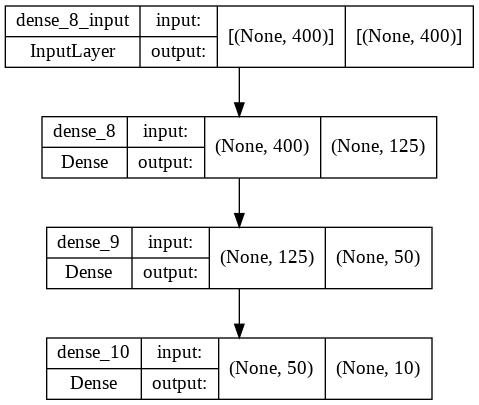

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model_ann, to_file=dot_img_file, show_shapes=True)

## Sortie du model
Vu que nous avons 10 noeurones alors pour chaque classe on aura un vecteur de prediction de dix valeurs de dimension (1,10)

In [ ]:
model_ann.output

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_10')>

## Compilation du model

In [ ]:
model_ann.compile(optimizer='adam',loss = "sparse_categorical_crossentropy", metrics=['accuracy'])

## Lancer l'entrainement du model

In [ ]:
model_ann.fit(xt,yt_rnn, epochs = 50)

Epoch 1/50
118/118 [==============================] - 1s 2ms/step - loss: 10.0183 - accuracy: 0.6125
Epoch 2/50
118/118 [==============================] - 0s 2ms/step - loss: 1.5800 - accuracy: 0.7805
Epoch 3/50
118/118 [==============================] - 0s 2ms/step - loss: 0.8638 - accuracy: 0.8467
Epoch 4/50
118/118 [==============================] - 0s 2ms/step - loss: 0.5774 - accuracy: 0.8773
Epoch 5/50
118/118 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.8808
Epoch 6/50
118/118 [==============================] - 0s 2ms/step - loss: 0.3380 - accuracy: 0.9131
Epoch 7/50
118/118 [==============================] - 0s 2ms/step - loss: 0.2583 - accuracy: 0.9283
Epoch 8/50
118/118 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.9368
Epoch 9/50
118/118 [==============================] - 0s 2ms/step - loss: 0.2656 - accuracy: 0.9328
Epoch 10/50
118/118 [==============================] - 0s 2ms/step - loss: 0.1952 - accuracy: 0.948

## Evaluation du modèle
Après avoir finis l'apprentissage de notre model, nous avons obtenu : 
  * Une Erreur de 9%
  * Une precision de : 93%

In [ ]:
model_ann.evaluate(Xtt_rnn, ytt_rnn)

40/40 [==============================] - 0s 2ms/step - loss: 0.9591 - accuracy: 0.9304


[0.9591025114059448, 0.930400013923645]

## Effectuer une prediction avec notre model

In [ ]:
model_ann.predict(Xtt_rnn)

array([[0.0000000e+00, 0.0000000e+00, 1.5204739e-14, ..., 2.3538137e-38,
        2.2028629e-13, 4.3670992e-21],
       [4.8648177e-19, 0.0000000e+00, 1.5025643e-30, ..., 5.5143916e-26,
        0.0000000e+00, 1.5008847e-24],
       [3.3029822e-27, 0.0000000e+00, 3.0374508e-31, ..., 0.0000000e+00,
        2.0444334e-33, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 4.6656790e-38, ..., 4.3492063e-23,
        0.0000000e+00, 1.0074577e-17],
       [7.3419525e-26, 1.9830149e-33, 1.0536545e-16, ..., 2.7939770e-37,
        1.0000000e+00, 3.2262559e-29],
       [0.0000000e+00, 0.0000000e+00, 3.1117659e-20, ..., 0.0000000e+00,
        1.0000000e+00, 1.3931996e-32]], dtype=float32)

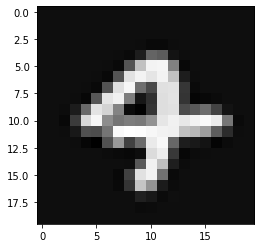

In [ ]:
plt.imshow(Xtt_rnn[10].reshape(20,20), cmap="gray")

In [ ]:
pre = model_ann.predict(Xtt_rnn)

In [ ]:
np.argmax(pre[10])

4

## Matrice de confusion

#### Avec notre fonction

In [ ]:
matrice_confusion_rnn = ConfusionMatrix(ytt_rnn,np.argmax(pre,axis = 1) )

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [ ]:
matrice_confusion_rnn

array([[138.,   0.,   3.,   0.,   0.,   0.,   0.,   1.,   0.,   1.],
       [  0., 117.,   3.,   0.,   0.,   0.,   1.,   0.,   1.,   1.],
       [  0.,   0., 114.,   2.,   2.,   0.,   1.,   1.,   5.,   1.],
       [  0.,   0.,   2., 107.,   1.,   1.,   0.,   1.,   2.,   2.],
       [  0.,   2.,   2.,   0., 106.,   0.,   1.,   1.,   1.,   5.],
       [  0.,   1.,   0.,   1.,   1., 113.,   0.,   0.,   0.,   2.],
       [  3.,   0.,   0.,   0.,   0.,   1., 117.,   0.,   1.,   1.],
       [  1.,   1.,   2.,   3.,   2.,   0.,   0., 129.,   2.,   1.],
       [  0.,   1.,   0.,   0.,   0.,   3.,   1.,   0., 100.,   1.],
       [  2.,   0.,   1.,   2.,   4.,   0.,   0.,   3.,   2., 122.]])

#### Avec Sklearn

In [ ]:
confusion_matrix(ytt_rnn,np.argmax(pre,axis = 1) )

array([[138,   0,   3,   0,   0,   0,   0,   1,   0,   1],
       [  0, 117,   3,   0,   0,   0,   1,   0,   1,   1],
       [  0,   0, 114,   2,   2,   0,   1,   1,   5,   1],
       [  0,   0,   2, 107,   1,   1,   0,   1,   2,   2],
       [  0,   2,   2,   0, 106,   0,   1,   1,   1,   5],
       [  0,   1,   0,   1,   1, 113,   0,   0,   0,   2],
       [  3,   0,   0,   0,   0,   1, 117,   0,   1,   1],
       [  1,   1,   2,   3,   2,   0,   0, 129,   2,   1],
       [  0,   1,   0,   0,   0,   3,   1,   0, 100,   1],
       [  2,   0,   1,   2,   4,   0,   0,   3,   2, 122]])

### Affichage de la matrice de confuision

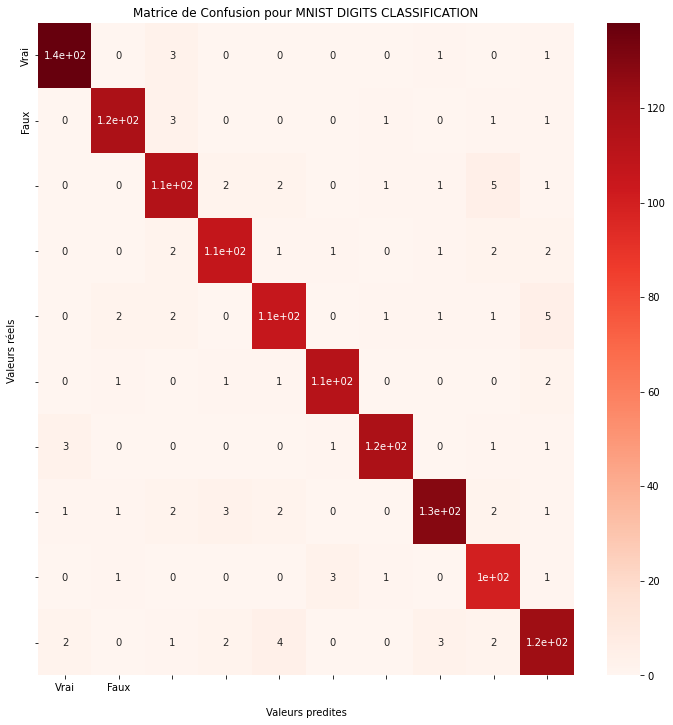

In [ ]:
AfficherMatriceConfusion((12,12), matrice_confusion_rnn)

# Calcule des metriques : Rappel, Precision, Taux de Faux positifs, Sensitivité pour la classe 1

In [ ]:
VP,FP,VN,FN = vp_np(mat_VP_FP(10,matrice_confusion_rnn),1)


Pour la classe  1
VP =  117.0  FP =  6.0  VN =  1046.0  FN =  81.0


In [ ]:
rappel_classe8 = rappel(VP,FN)

In [ ]:
precision_classe8 = precision(VP,FP)

In [ ]:
taux_faux_positif_classe8 = taux_FP(FP,VP)

In [ ]:
specificite_classe8 = specificite(VP,FP)

In [ ]:
print("classe1\n","rappel = ", rappel_classe8," precision = ",precision_classe8," taux de faux positif = ", taux_faux_positif_classe8," specificite = ",specificite_classe8)

classe1
 rappel =  0.5909090909090909  precision =  0.9512195121951219  taux de faux positif =  0.04878048780487805  specificite =  0.9512195121951219


# Courbe Roc

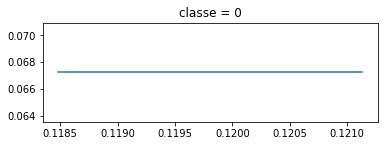

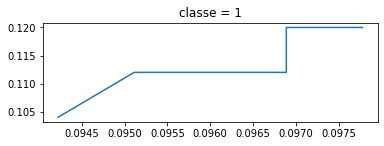

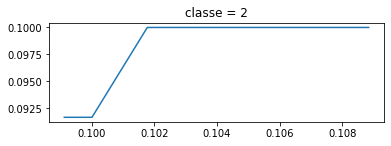

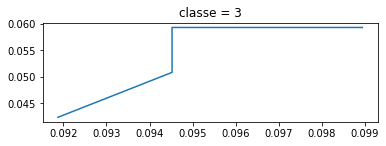

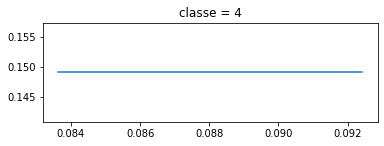

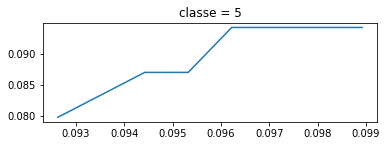

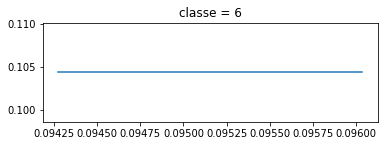

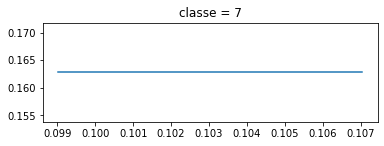

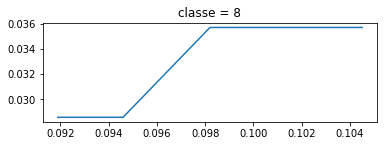

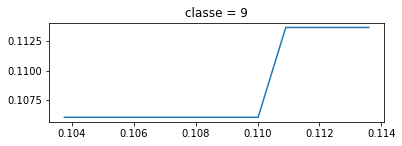

In [ ]:
ROC(vect_classes, seuils,Ytt,pre)

#RNC

In [ ]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [ ]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# evaluaer le modèle
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)


In [ ]:
model.fit(Xt_rncN,Yt_rnc, epochs = 5)

Epoch 1/5
47/47 [==============================] - 1s 10ms/step - loss: 1.0619 - accuracy: 0.6627
Epoch 2/5
47/47 [==============================] - 1s 11ms/step - loss: 0.4198 - accuracy: 0.8653
Epoch 3/5
47/47 [==============================] - 1s 11ms/step - loss: 0.3031 - accuracy: 0.8967
Epoch 4/5
47/47 [==============================] - 0s 10ms/step - loss: 0.2354 - accuracy: 0.9340
Epoch 5/5
47/47 [==============================] - 0s 10ms/step - loss: 0.1857 - accuracy: 0.9513


In [ ]:
# evaluaer le modèle
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)

## Evaluation du model CNN : 
Precision de  : 90%

In [ ]:
acc

0.9097142815589905

## Calculer les predictions du model sur toutes la base de données

In [ ]:
prediction_cnn = model.predict(Xtt_rncN)

In [ ]:
Ytt.shape

(3500,)

In [ ]:
prediction_cnn.shape


(3500, 10)

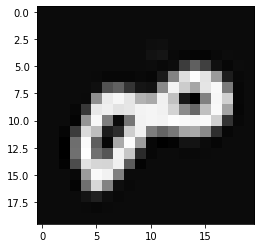

In [ ]:
plt.imshow(Xtt[10].reshape(20,20), cmap = "gray")

In [ ]:
np.argmax(prediction_cnn[10])

8

## Matrice de confusion

### Avec notre fonction

In [ ]:
matrice_confusion_cnn = ConfusionMatrix(Ytt,np.argmax(prediction_cnn, axis=1))

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [ ]:
ConfusionMatrix(Ytt,np.argmax(prediction_cnn, axis=1))

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


array([[342.,   1.,   1.,   2.,   1.,   4.,   1.,   2.,   0.,   0.],
       [  0., 343.,   1.,   1.,   2.,   2.,   0.,   0.,   2.,   0.],
       [  4.,   4., 322.,   9.,   3.,   0.,   1.,   3.,   7.,   1.],
       [  0.,   2.,   4., 324.,   0.,  15.,   1.,   2.,   6.,   4.],
       [  0.,   6.,   5.,   0., 312.,   0.,   2.,   0.,   2.,  11.],
       [  1.,   1.,   1.,   8.,   5., 320.,   1.,   0.,   9.,   5.],
       [  4.,   3.,   0.,   0.,   2.,  13., 319.,   0.,   1.,   1.],
       [  1.,  12.,   5.,   7.,   7.,   0.,   0., 270.,   0.,  48.],
       [  1.,   3.,   3.,  15.,   0.,  10.,   0.,   0., 311.,   7.],
       [  4.,   4.,   2.,   9.,   5.,   2.,   0.,   3.,   1., 321.]])

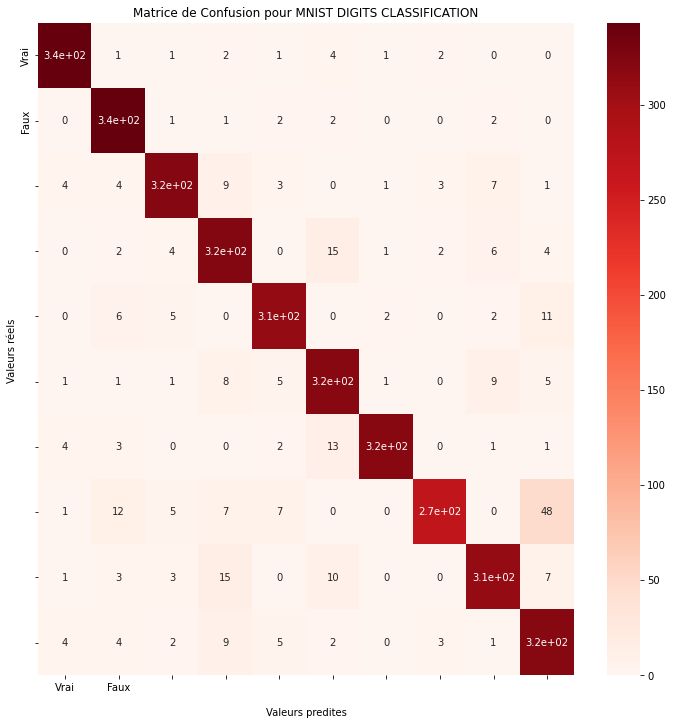

In [ ]:
AfficherMatriceConfusion((12,12),matrice_confusion_cnn)

### Avec Sklearn

In [ ]:
confusion_matrix(Ytt,np.argmax(prediction_cnn, axis=1))

array([[342,   1,   1,   2,   1,   4,   1,   2,   0,   0],
       [  0, 343,   1,   1,   2,   2,   0,   0,   2,   0],
       [  4,   4, 322,   9,   3,   0,   1,   3,   7,   1],
       [  0,   2,   4, 324,   0,  15,   1,   2,   6,   4],
       [  0,   6,   5,   0, 312,   0,   2,   0,   2,  11],
       [  1,   1,   1,   8,   5, 320,   1,   0,   9,   5],
       [  4,   3,   0,   0,   2,  13, 319,   0,   1,   1],
       [  1,  12,   5,   7,   7,   0,   0, 270,   0,  48],
       [  1,   3,   3,  15,   0,  10,   0,   0, 311,   7],
       [  4,   4,   2,   9,   5,   2,   0,   3,   1, 321]])

## Calcul des metriques : Rappel, Precision, Specificité, Sensitivité classe 1

In [ ]:
VP,FP,VN,FN = vp_np(mat_VP_FP(10,matrice_confusion_cnn),1)


Pour la classe  1
VP =  343.0  FP =  8.0  VN =  2841.0  FN =  308.0


In [ ]:
rappel_classe8 = rappel(VP,FN)

In [ ]:
precision_classe8 = precision(VP,FP)

In [ ]:
taux_faux_positif_classe8 = taux_FP(FP,VP)

In [ ]:
specificite_classe8 = specificite(VP,FP)

In [ ]:
print("classe1\n","rappel = ", rappel_classe8," precision = ",precision_classe8," taux de faux positif = ", taux_faux_positif_classe8," specificite = ",specificite_classe8)

classe1
 rappel =  0.5268817204301075  precision =  0.9772079772079773  taux de faux positif =  0.022792022792022793  specificite =  0.9772079772079773


## Courbe roc

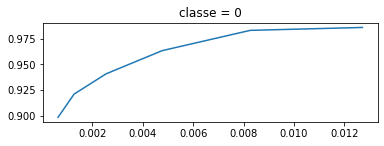

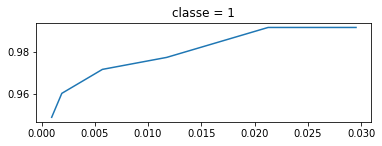

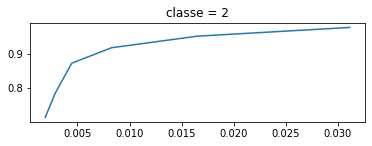

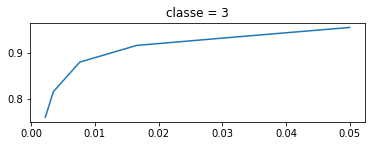

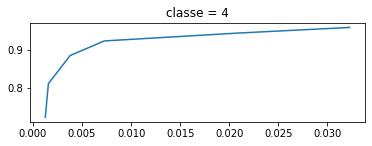

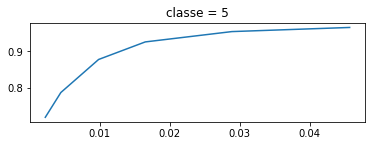

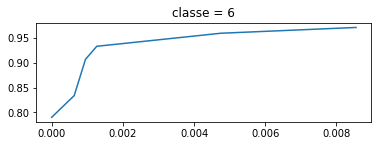

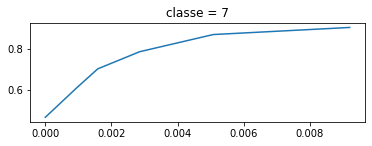

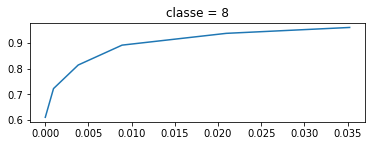

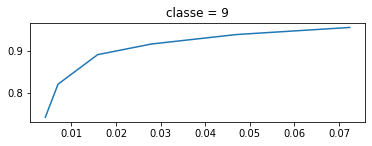

In [ ]:
ROC(vect_classes,seuils, Ytt,prediction_cnn)